In [1]:
import torch
import torch.nn.functional as F
import torchsde

from torchvision import datasets, transforms

import math
import numpy as np
import pandas as pd
from tqdm import tqdm

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import functorch

import matplotlib.pyplot as plt

from scipy.io import loadmat

from cfollmer.evaluation_utils import ECE
import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
meg_data = pd.read_csv("../data/MEG_art", header=None, sep="  ").to_numpy()

/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [4]:
N_total = meg_data.shape[1]
N_train = int(0.8 * N_total)
N_test = N_total - N_train
n_channels = 10
dim = n_channels ** 2

In [5]:
X_train = meg_data[:n_channels, :N_train].T
X_test = meg_data[:n_channels, N_train:].T

X_train = torch.tensor(X_train, device=device, dtype=torch.float)
X_test = torch.tensor(X_test, device=device, dtype=torch.float)

std, mu = torch.std_mean(X_train, 0)

X_train = (X_train - mu) / std
X_test = (X_test - mu) /std

In [6]:
sigma2 = 1.0

def log_prior(W):
    return - torch.sum(W**2) / (2 * sigma2)

def log_likelihood(x, W):
    W = W.view(n_channels, n_channels)
    return x.shape[0] * torch.log(torch.abs(torch.det(W))) - 2 * torch.sum(torch.log(torch.cosh(x @ W)))

def log_likelihood_batch(x, W_batch):
    func = lambda W: log_likelihood(x, W)
    func = torch.vmap(func)
    return func(W_batch)

def log_posterior(x, W):
    return log_prior(W) + (N_train / x.shape[0]) * log_likelihood(x, W)

def log_posterior_batch(x, W_batch):
    func = lambda W: log_posterior(x, W)
    func = torch.vmap(func)
    return func(W_batch)

In [7]:
def train(gamma, n_epochs, data_batch_size, param_batch_size, dt=0.05):
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=dim, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []

    for _ in range(n_epochs):
        epoch_losses = []

        perm = torch.randperm(N_train)

        for i in tqdm(range(0, N_train, data_batch_size)):
            x = X_train[perm[i:min(i + data_batch_size, N_train)]]
            
            optimizer.zero_grad()
            
            partial_log_p = lambda params_batch: log_posterior_batch(x, params_batch)
        
            loss = relative_entropy_control_cost(sde, partial_log_p, param_batch_size=param_batch_size, dt=dt, device=device)
            loss.backward()
            
            epoch_losses.append(loss.detach().cpu().numpy())
            optimizer.step()

        losses.append(epoch_losses)
    
    losses = np.array(losses)
    
    return sde, losses

In [8]:
gamma = 0.01**2
n_epochs = 2
data_batch_size = 10
param_batch_size = 32

In [9]:
sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size)

  0%|                                                                       | 0/1419 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
/tmp/ipykernel_772716/194113635.py:20: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|█████████████████████████████████████████

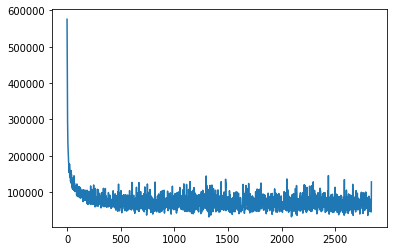

In [10]:
plt.plot(losses.flatten())

In [11]:
with torch.no_grad():
    W_samples = sde.sample(100, dt=0.01, device=device)
    logp = log_likelihood_batch(X_test, W_samples)
    logp = torch.mean(logp) / N_test

/tmp/ipykernel_772716/194113635.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


In [12]:
n_runs = 5

logps = []

for i in range(n_runs):
    sde, losses = train(gamma, n_epochs, data_batch_size, param_batch_size)
    
    with torch.no_grad():
        W_samples = sde.sample(100, dt=0.01, device=device)
        logp = log_likelihood_batch(X_test, W_samples)
        logp = torch.mean(logp) / N_test
    
    logps.append(logp)
    
logps = torch.stack(logps)

  0%|                                                                       | 0/1419 [00:00<?, ?it/s]/home/ao464@ad.eng.cam.ac.uk/repos/ControlledFollmerDrift/env/lib/python3.8/site-packages/torch/nn/functional.py:2384: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::batch_norm. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at  /tmp/pip-req-build-b9xxrrfi/functorch/csrc/BatchedFallback.cpp:106.)
  return torch.batch_norm(
/tmp/ipykernel_772716/194113635.py:20: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|█████████████████████████████████████████

In [13]:
SBP_logps = logps

In [15]:
@torch.enable_grad()
def gradient(x, W):
    W_ = W.clone().requires_grad_(True)
    loss = log_posterior(x, W_)
    grad, = torch.autograd.grad(loss, W_)
    return loss.detach().cpu().numpy(), grad

In [16]:
def step_size(n):
    return 0.00001 / (1 + n)**0.5

In [17]:
def sgld(n_epochs, data_batch_size):
    W = torch.randn(dim).float().to(device)
    step = 0

    losses = []
    logps = []
    W_samples = []
    
    for _ in range(n_epochs):
        perm = torch.randperm(N_train)

        for i in tqdm(range(0, N_train, data_batch_size)):
            x = X_train[perm[i:min(i + data_batch_size, N_train)]]

            eps = step_size(step)
            loss, grad = gradient(x, W)
            W = W + 0.5 * eps * grad + np.sqrt(eps) * torch.randn_like(W)
            step += 1
            losses.append(loss)
            W_samples.append(W)
            
            with torch.no_grad():
                logp = log_likelihood(X_test, W) / N_test
                logps.append(logp.cpu().numpy())
            
    return W_samples, losses, logps

In [18]:
W_samples, losses, logps = sgld(n_epochs, data_batch_size)

100%|██████████████████████████████████████████████████████████| 1419/1419 [00:01<00:00, 1070.30it/s]


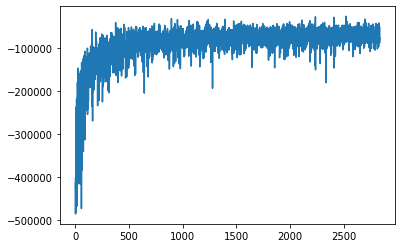

In [19]:
plt.plot(losses)

In [20]:
W_samples = torch.stack(W_samples[-100:])

In [21]:
logp = log_likelihood_batch(X_test, W_samples)
logp = torch.mean(logp) / N_test

/tmp/ipykernel_772716/194113635.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)


In [22]:
logp

tensor(-5.0995, device='cuda:0')

In [28]:
n_runs = 5
logps = []

for i in range(n_runs):
    W_samples, _, _ = sgld(n_epochs, data_batch_size)
    W_samples = torch.stack(W_samples[-100:])
    logp = log_likelihood_batch(X_test, W_samples)
    logp = torch.mean(logp) / N_test
    logps.append(logp)
    
logps = torch.stack(logps)

100%|██████████████████████████████████████████████████████████| 1419/1419 [00:01<00:00, 1082.04it/s]
/tmp/ipykernel_772716/194113635.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  func = torch.vmap(func)
100%|██████████████████████████████████████████████████████████| 1419/1419 [00:01<00:00, 1039.24it/s]


In [29]:
SGLD_logps = logps

In [30]:
SGLD_logps

tensor([-4.9409, -4.8758, -4.9943, -4.9413, -4.9277], device='cuda:0')

In [31]:
df = pd.DataFrame({"SBP": SBP_logps.cpu().numpy(), "SGLD": SGLD_logps.cpu().numpy()})

In [32]:
df

,SBP,SGLD
0,-5.090768,-4.940926
1,-4.912477,-4.875788
2,-5.268039,-4.994345
3,-5.137437,-4.941348
4,-5.146138,-4.927700


In [33]:
df.describe()

,SBP,SGLD
count,5.000000,5.000000
mean,-5.110972,-4.936021
std,0.128856,0.042283
min,-5.268039,-4.994345
25%,-5.146138,-4.941348
50%,-5.137437,-4.940926
75%,-5.090768,-4.927700
max,-4.912477,-4.875788
